# Analyzing Economic and Data
In this tutorial, we will use several examples to show how we can analyze issues in economics. We will discuss the following topics:
1. [GDP](#GDP)
2. [Income Inequality](#Income-Inequality)

## Pre-requisites
```bash
pip3 install pandas geopandas numpy matplotlib seaborn
```

In [1]:
#import libraries
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

## GDP
### Introduction

[Wikipedia page of GDP](https://en.wikipedia.org/wiki/Gross_domestic_product)

Gross Domestic Product, or GDP, is a common measure of the economic performance of a country. According to the International Monetary Fund, *"GDP measures the monetary value of final goods and services—that is, those that are bought by the final user—produced in a country in a given period of time"*. The time is usually in years or quarters, but could be defined in other intervals such as months or decades. *"Final"* is important since we want to know the total value created during the period, rather than the amount of value exchanged during the period. There are many methods of calculating GDP, but most of the time financial authorities evaluate it using the *Expenditure Approach*.

In the Expenditure Approach, we break down GDP(Y) in to 5 factors:

Y = C + I + G + (X - M)
1. Consumption(C), or Personal Consumption Expenditure: In most cases, this is the major factor of GDP. It represents the amount of goods consumed by households, and can be broken down into even smaller categories such as durable goods(e.g. cars, computers, furniture etc.), nondurable goods(e.g. food, beverages, clothing etc.) and services(e.g. rent, medical insurance etc.). Purchases of houses are not included in this factor but in Investment.
2. Investments(I), or Gross Private Domestic Investment: This is the amount of purchases of fixed long-term assets(e.g. factories, infrastructure) of private businesses, household house purchases and the change of inventory of private businesses, which can be seen as their investments on inventory.
3. Goverment Spending(G), or Goverment Consumption Expenditures and Gross Investment: This measures the amount of goods and services that the government purchases to provide to the public, such as weapons for national defense and school facilities for education. This does not include social benefits such as medical insurance.
4. Exports(X): Exported goods and services creates value for the exporting country.
5. Imports(M): Imports are deducted from the calculation since their value will already be included in other factors.

Exports and Imports are often seen as one term - *Net Export*.

We obtain raw data from the United States Bureau of Economic Analysis(BEA). The dataset that we use is the [Table 1.1.6 Real Gross Domestic Product, Chained Dollars](https://www.bea.gov/iTable/iTable.cfm?reqid=19&step=2#reqid=19&step=3&isuri=1&1921=survey&1903=6), from 1947 to 2017. Chained dollars is a complex method to adjust the weight of currency, making the measurements more suitable to compare. We use this time range is that prior 1947 there was only annual data. You can play around with the interactive features of the data. If you want to download the data, save it as a csv file and rename it to ```usgdp1947_2017.csv```.

In [2]:
## Preprocessing the data
# the data is full of notes and we need to clean it up
gdp_df = pd.read_csv("usgdp1947_2017.csv", header=[4,5], index_col=1, na_values="---")
gdp_df = gdp_df.iloc[:, 1:]
gdp_df.dropna(how="all", inplace=True)

# the cols are padded with spaces, remove them for easier access
gdp_df.rename(lambda x: "_".join(x.strip().lower().split()), inplace=True)

# transpose the dataframe to get the time periods as the indexes
gdp_df = gdp_df.T

# set the index as PeriodIndex representing the quarter the row is representing
quarter_idx = gdp_df.index.map(lambda x:pd.Period(value="".join(x)))
gdp_df.set_index(quarter_idx, inplace=True)

gdp_df.tail()

,gross_domestic_product,personal_consumption_expenditures,goods,durable_goods,nondurable_goods,services,gross_private_domestic_investment,fixed_investment,nonresidential,structures,...,services,imports,goods,services,government_consumption_expenditures_and_gross_investment,federal,national_defense,nondefense,state_and_local,residual
2016Q4,16851.4,11702.1,4138.4,1647.9,2533.2,7573.8,2905.7,2820.3,2224.9,452.1,...,670.6,2755.5,2260.7,492.4,2901.2,1115.2,664.1,450.3,1784.1,-55.2
2017Q1,16903.2,11758.0,4145.4,1647.3,2540.2,7621.0,2897.0,2875.7,2263.6,468.0,...,672.2,2784.5,2286.7,495.5,2896.6,1108.4,658.6,449.0,1786.2,-54.0
2017Q2,17031.1,11853.0,4199.9,1677.8,2566.6,7664.4,2924.7,2898.5,2300.6,476.0,...,682.3,2794.8,2294.3,498.2,2895.2,1113.7,666.2,446.9,1779.6,-63.5
2017Q3,17163.9,11916.6,4246.0,1712.9,2581.5,7685.5,2976.5,2915.8,2326.9,467.4,...,686.6,2790.0,2292.9,494.8,2900.0,1117.4,670.2,446.6,1780.7,-77.4
2017Q4,17271.7,12027.9,4323.5,1769.1,2609.1,7725.0,3002.5,2972.8,2364.4,470.3,...,683.4,2882.7,2384.0,497.1,2920.6,1126.4,679.4,446.6,1792.4,-87.2


Let's plot the GDP from 1947 to 2017 and get a clue of what it looks like.

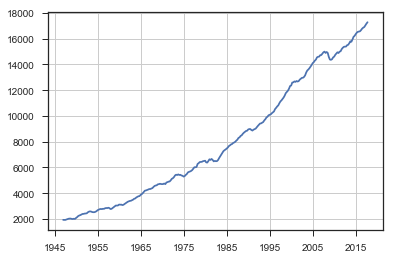

In [3]:
plt.plot(gdp_df.index.to_timestamp(), gdp_df["gross_domestic_product"])
plt.grid()

We can see from the overall trend that the GDP is growing steadily. The decline near 1974 was the Oil Crisis while the dent around 2008 is when the subprime economic crisis happened. Now let's see how each factor impacts the product.

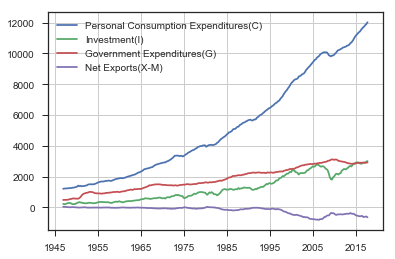

In [4]:
factor_cols = [
    'personal_consumption_expenditures',
    'gross_private_domestic_investment',
    'government_consumption_expenditures_and_gross_investment']
    
gdp_factors_df = gdp_df.loc[:,factor_cols]
gdp_factors_df = gdp_factors_df.assign(net_exports=gdp_df['exports'] - gdp_df['imports'])
lines = plt.plot(gdp_factors_df.index.to_timestamp(), gdp_factors_df)
plt.legend(lines, [
    'Personal Consumption Expenditures(C)',
    'Investment(I)',
    'Government Expenditures(G)',
    'Net Exports(X-M)'])
plt.grid()

We can see that personal consumption is indeed contributes the largest amount to final value. It is interesting that during the 2008 financial crisis, we can see that the contribution of the private sector decreased, while the government expenditure increased.

This gives us some insight of GDP itself, but sometimes what we care more is the growth. In economics, we take the logarithm of the measurements before calculating the growth rate. It has something to do with compound rates and relative growth. You can get more detailed information from [here](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics).

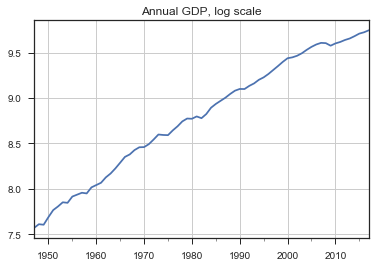

In [5]:
annual_gdp = gdp_df['gross_domestic_product'].resample("A").mean()
log_annual_gdp = np.log(annual_gdp)
log_annual_gdp.plot(title="Annual GDP, log scale")
plt.grid()

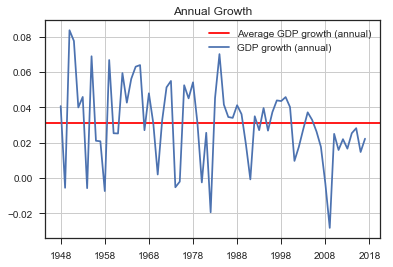

In [6]:
# for single period growth rate, we can approximate the growth rate as g_(t+1) - g_t
# where g_n is the nth period natural logged GDP
annual_growth = log_annual_gdp.diff(1)
avg_line = plt.axhline(annual_growth.mean(), color='r')
gdp_line = plt.plot(log_annual_gdp.index.to_timestamp(),annual_growth)
plt.legend([avg_line]+ gdp_line, ["Average GDP growth (annual)", "GDP growth (annual)"])
plt.title("Annual Growth")
plt.grid()

We can easily see from the annual growth rate the booms and busts of the economy, where outliers can often relate to major global events, such as the [post-WWII Golden Age](https://en.wikipedia.org/wiki/Post–World_War_II_economic_expansion), [1974 Oil Crisis](https://en.wikipedia.org/wiki/1973_oil_crisis), [Dot-Com Bubble](https://en.wikipedia.org/wiki/Dot-com_bubble) and [Subprime Crisis](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis) etc. It seems that the overall growth of US has slowed down after 2008. What is the growth of individual factors? How do they correlate with the overall growth of the GDP?

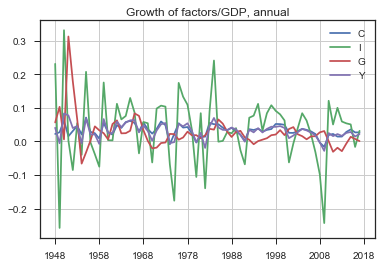

In [7]:
# exclude net exports since it's sign is variable, leading to errors in log
annual_factors = gdp_factors_df.drop("net_exports", axis=1).resample("A").mean()
log_annual_factors = annual_factors.apply(np.log)
annual_factors_growth = log_annual_factors.diff(1)
factor_lines = plt.plot(log_annual_gdp.index.to_timestamp(), annual_factors_growth)
gdp_line = plt.plot(log_annual_gdp.index.to_timestamp(), annual_growth)
plt.legend(factor_lines+gdp_line, ["C","I","G","Y"])
plt.title("Growth of factors/GDP, annual")
plt.grid()

In [8]:
# Volatility of factors' growth compared to GDP's growth
annual_factors_growth.var()/annual_growth.var()

personal_consumption_expenditures                            0.595426
gross_private_domestic_investment                           19.836591
government_consumption_expenditures_and_gross_investment     4.511126
dtype: float64

In [9]:
# Correlation between the factors' growth and GDP growth
annual_factors_growth.corrwith(annual_growth)

personal_consumption_expenditures                           0.823895
gross_private_domestic_investment                           0.817154
government_consumption_expenditures_and_gross_investment    0.251837
dtype: float64

In [10]:
# Correlation between factors' growth
annual_factors_growth.corr()

,personal_consumption_expenditures,gross_private_domestic_investment,government_consumption_expenditures_and_gross_investment
personal_consumption_expenditures,1.000000,0.672597,-0.040090
gross_private_domestic_investment,0.672597,1.000000,-0.207546
government_consumption_expenditures_and_gross_investment,-0.040090,-0.207546,1.000000


From here, we can observe various interesting facts of the different factors. First, we can see both from the chart and from the volatility of the factors that private investment varies a lot throughout the time. It is still, however, highly correlated to GDP itself. We might get some insight that private sectors have greater reactions to fluctations of the economy, while personal consumption might not be going to the extremes since people have to obtain basic necessities to survive. Meanwhile, since personal consumption is the largest component of GDP, it is not surprising that it has such high correlation with GDP. It is also interesting that government spendings are negatively correlated to the other factors, which might be justified since the government will jump in and provide subsidies hoping to resurrect the market from bad conditions.

The last thing we are going to mention about is GDP per capita, which is the average GDP contribution per person. Since every country has a different population, it is hard to compare the standard of living between borders. We usually take PPP(Purchase Power Parity) into account to mitigate the fact that the same basket of products will have different prices in different places. You can obtain the following dataset from [IMF](http://www.imf.org/external/datamapper/PPPPC@WEO/OEMDC/ADVEC/WEOWORLD). For some reason, you'll have to open the XLS file with Excel and save it again before loading.

In [11]:
gdp_ppp_cap_df = pd.read_excel("gdp_ppp_per_capita_2018.xls", skiprows=[1], na_values=["no data"], index_col=[0], skip_footer=34).dropna(how="all")
sorted_gdp_ppp_cap_2017 = gdp_ppp_cap_df[2017].dropna().sort_values()[::-1]

print("Countries with highest GDP(PPP) per capita in 2017:")
print(sorted_gdp_ppp_cap_2017.head())

print("\nCountries with median GDP(PPP) per capita in 2017:")
print(sorted_gdp_ppp_cap_2017.iloc[int(len(sorted_gdp_ppp_cap_2017)/2-3):int(len(sorted_gdp_ppp_cap_2017)/2+3)])

print("\nCountries with lowest GDP(PPP) per capita in 2017:")
print(sorted_gdp_ppp_cap_2017.tail())

Countries with highest GDP(PPP) per capita in 2017:
GDP per capita, current prices (Purchasing power parity; international dollars per capita)
Qatar                124927.438
Macao SAR            114429.785
Luxembourg           109191.775
Singapore             90531.401
Brunei Darussalam     76743.074
Name: 2017, dtype: float64

Countries with median GDP(PPP) per capita in 2017:
GDP per capita, current prices (Purchasing power parity; international dollars per capita)
Peru         13341.860
Sri Lanka    13000.781
Egypt        12993.967
Mongolia     12550.826
Jordan       12487.332
Albania      12471.736
Name: 2017, dtype: float64

Countries with lowest GDP(PPP) per capita in 2017:
GDP per capita, current prices (Purchasing power parity; international dollars per capita)
Niger                       1152.691
Liberia                      867.102
Burundi                      808.285
Congo, Dem. Rep. of the      784.595
Central African Republic     681.224
Name: 2017, dtype: float64


We can gain lots of insights from GDP, but there are many limitations on the information we can retrieve from this measurement, one of them is the distribution of income.

## Income Inequality
Measuring the distribution of income and how it is distributed has always been an important issue in economics. 
### Gini Coefficient
[Wikipedia page of Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient)

The Gini Coefficient is a common index to indicate the inequality of income.
When calculating the index, we first sort our raw data. Now, starting from the lowest value, we calculate the cumulative share of the total wealth for each individual. This will lead to the following diagram, where the left side of the squarer is the lowest and right side the highest. Suppose there are no negative values, the share will start from 0 and eventually increase to 1. The frontier that the individual shares form is the Lorenze Curve.
![Diagram of Gini coefficient](https://upload.wikimedia.org/wikipedia/commons/5/59/Economics_Gini_coefficient2.svg)
(Src: Wikimedia)

The straight line with unity slope represents the line of equality, which is what the cumulative shares will look like if everyone has the same income. Oppositely, if all of the wealth were in one individual's hand, the Lorenz curve would be a flat line at y=0 and jump up to 1 when x=1. These events are unlikely to happen in the real world, the Lorenz curve would look like something between these two extremes. Gini Coefficient is calcuated by the ratio between A (the area enclosed by the line of equality and Lorenz curve) and A+B (the area under the line of equality, which is always 0.5).

Let's start with defining a function to calcuate the Gini Coefficient for an arbritrary income share distribution.

In [12]:
def gini_coeff(sorted_share_percentage, percentiles):
    # sorted_share and percentile are both ndarrays
    # assume linear interpolation between percentiles
    # then we are calculating trapezoid areas
    cumulative_share = np.append(0, sorted_share_percentage.cumsum()/100)
    percentiles = np.append(0, percentiles/100)
    area = 0 # area of B
    for s1, s2, p1, p2 in zip(cumulative_share[:-1], cumulative_share[1:], percentiles[:-1], percentiles[1:]):
        area += (s1+s2)*(p2-p1)/2
    return 1-2*area # A/A+B = A/0.5 = (0.5-B)/0.5 = 1-2B

In [13]:
# gini coefficient for uniformly distributed with n samples
n1 = 10
gini_coeff(100*np.ones(n1)/n1, np.arange(0,100,100/n1)+100/n1)

0.0

In [14]:
# gini coefficient for extremely skewed distributions
n2 = 10
gini_coeff(100*np.append(np.zeros(n2-1),1), np.arange(0,100,100/n2)+100/n2)

0.90000000000000002

We can see that in uniform distribution, the Gini coefficient is 0, since the area between the Lorenz curve and the line of equality is 0. On the other hand, when there is monopoly in wealth, the coefficient gets near 1. It will not be one since we are interpolating with trapezoids, but you can get the idea.

## United States Income Inequality
We now use the Gini Coefficient to evaluate income distributions of the US. The best data we can get are the annually published income quintiles (i.e. splitting the total distribution into 5 folds). We can obtain the dataset from the [United States Census Bureau](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-inequality.html). We will be using [Table H-2, all races](https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h02ar.xls) for calculation.

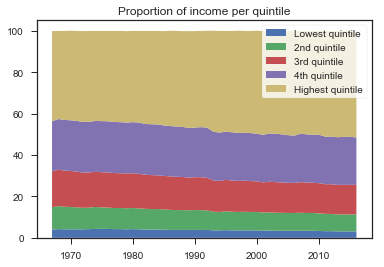

In [15]:
# read the excel file
income_share_df = pd.read_excel("1967_2016_incomeshare.xls", names=["year","number",20,40,60,80,100,"top 5"], skiprows=4,skip_footer=1)

# remove duplicates since we just want to see an overall trend
income_share_df["year"] = income_share_df["year"].apply(lambda x: pd.Timestamp(str(x)[:4]))
income_share_df.drop_duplicates(subset=["year"], inplace=True)
income_share_df.set_index(income_share_df["year"], inplace=True)
income_share_df.drop("year", axis=1, inplace=True)

percentiles = np.arange(0,100,20)+20

plt.stackplot(income_share_df.index, income_share_df[percentiles].T, labels=["Lowest quintile","2nd quintile","3rd quintile","4th quintile","Highest quintile"])
plt.legend(facecolor="white",frameon=True)
_ = plt.title("Proportion of income per quintile")

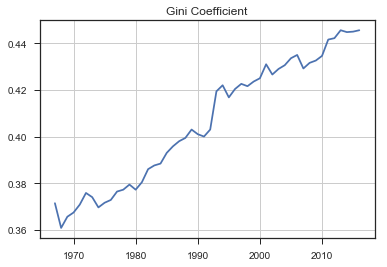

In [16]:
us_gini = income_share_df.apply(lambda x: gini_coeff(x.loc[percentiles], percentiles), axis=1)
plt.plot(income_share_df.index, us_gini)
plt.title("Gini Coefficient")
plt.grid()

We can see that the share of total wealth of the highest quintile has grown to almost 50%, which strongly suggests that the inequality has increased. This can be seen from the increase of the Gini coefficient. Let's see what happens if we utilize the *Top 5%* data.

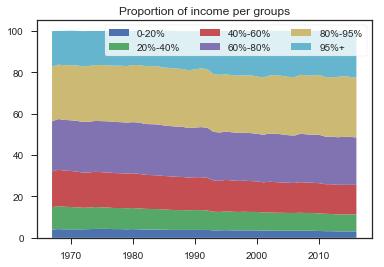

In [17]:
income_share_df2 = income_share_df.copy()
income_share_df2[95] = income_share_df[100] - income_share_df["top 5"]
income_share_df2[100] = income_share_df["top 5"]
percentiles = np.array([20,40,60,80,95,100])
plt.stackplot(income_share_df.index, income_share_df2[percentiles].T, labels=["0-20%","20%-40%","40%-60%","60%-80%","80%-95%","95%+"])
plt.legend(facecolor="white",frameon=True, ncol=3)
_ = plt.title("Proportion of income per groups")

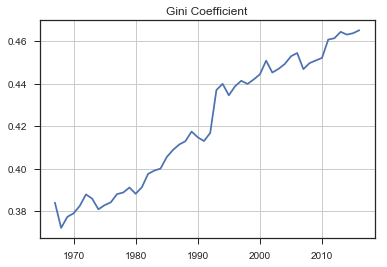

In [18]:
us_gini2 = income_share_df2.apply(lambda x: gini_coeff(x.loc[percentiles], percentiles), axis=1)
plt.plot(income_share_df2.index, us_gini2)
plt.title("Gini Coefficient")
plt.grid()

We can see that integrating the *Top 5%* data shows that the distribution is even more skewed. The top 5% of the total population controls 20% of the total wealth, which is even more than the total of the lower 40%. One thing to mention is that since we are calculating the values with only quintile information, the actual value published from authorities will differ from our estimation since they use raw data for computation. It still gives us a rough picture of what the trend looks like.

## Income Inequality in the World
We now try to compare the Gini Coefficients of other countries, using the WIID (World Income Inequality Database) [dataset](https://www.wider.unu.edu/database/world-income-inequality-database-wiid34). We will plot it on the world map and see if there are any insights between geolocation factors and income inequality.

In [19]:
wiid_df = pd.read_excel("world_income_inequality_database.xlsx", index_col="Countrycode3", usecols=["Country","Countrycode3","Year","Gini", "Source", "Welfaredefn_new"])

In [20]:
# Use multiple year data to increase number of datapoints
# Take the mean of the different datapoints
wiid_df.dropna(inplace=True)
gini_201x = wiid_df[(wiid_df["Year"]>=2008) & (wiid_df["Year"]<=2012)]\
        .groupby("Countrycode3")\
        .mean()

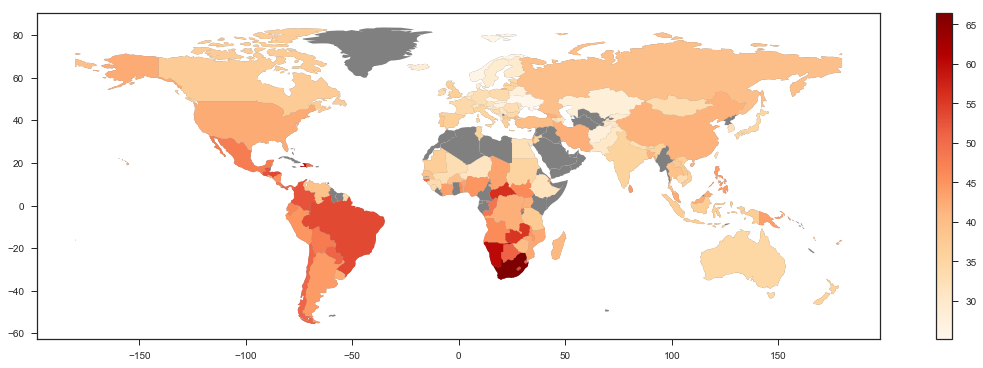

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
    
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.set_aspect('equal')
world.plot(ax = ax,color="grey")

gini_map = world.merge(gini_201x, left_on="iso_a3", right_index=True)
_ = gini_map.plot(ax = ax, column="Gini",cmap='OrRd', legend=True)

We can see from the map that most of the developed countries have lower income inequality than their emerging/undeveloped counterparts. It can also be seen that South America and southern Africa are suffering higher inequality.

## Change of income inequality in different countries
We now use the same data from WIID, but this time we want to track the changes of Gini Coefficient. We use only OECD data to maintain consistency.

In [22]:
wiid_df["Year"] = wiid_df["Year"].apply(lambda x: pd.Timestamp(str(x)))
oecd_df = wiid_df[wiid_df["Source"]=="OECD StatExtract"]
oecd_df.head(10)

,Country,Year,Gini,Source,Welfaredefn_new
Countrycode3,,,,,
AUS,Australia,1995-01-01,30.9,OECD StatExtract,"Income, disposable"
AUS,Australia,1995-01-01,46.7,OECD StatExtract,"Income, gross"
AUS,Australia,2000-01-01,31.7,OECD StatExtract,"Income, disposable"
AUS,Australia,2000-01-01,47.6,OECD StatExtract,"Income, gross"
AUS,Australia,2004-01-01,31.5,OECD StatExtract,"Income, disposable"
AUS,Australia,2004-01-01,46.5,OECD StatExtract,"Income, gross"
AUS,Australia,2008-01-01,33.6,OECD StatExtract,"Income, disposable"
AUS,Australia,2008-01-01,46.8,OECD StatExtract,"Income, gross"
AUS,Australia,2010-01-01,33.4,OECD StatExtract,"Income, disposable"


We can see that for most of the countries, there are two entries per year. Gross income is before taxes deductions, while disposable income is the net income that can be used freely. We can therefore see what taxes do to try narrowing the gap between the extremes.

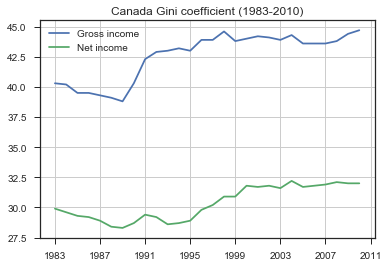

In [23]:
# use Canada to show influence of taxes
can_df = oecd_df[oecd_df["Country"] == "Canada"]
# exclude 2011 since it doesn't have both entries
can_df = can_df[can_df["Year"] < pd.Timestamp("2011")]
can_df.set_index("Year", inplace=True)
gross_idx = can_df["Welfaredefn_new"]=="Income, gross"
can_gross = can_df.loc[gross_idx, "Gini"]
can_net = can_df.loc[~gross_idx, "Gini"]

fig, ax = plt.subplots()
lines = ax.plot(can_gross.index, np.stack([can_gross, can_net]).T)
ax.legend(lines, ["Gross income","Net income"])
plt.title("Canada Gini coefficient (1983-2010)")
plt.grid()

Taxes are definitely redistributing relative wealth, which is why income tax brackets (i.e. cumulative tax rates) exist. But the Gini coefficient can't tell us how much tax is imposed on the individuals, it only tells us that the gap between the poor and rich have been reduced. It could be possible that the country taxes heavily and everyone gets poor nominaly, but the Gini coefficient will still reduce since everyone is poor now.

We plot a few other countries and see if there is anything interesting.

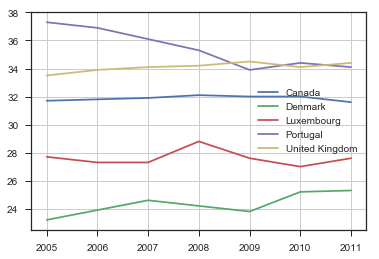

In [24]:
oecd_net_df = oecd_df[(oecd_df["Welfaredefn_new"]=="Income, disposable") &
                      (oecd_df["Year"] > pd.Timestamp("2004")) &
                      (oecd_df["Year"] <=pd.Timestamp("2011"))
                     ]
countries = ["Denmark", "Luxembourg", "Canada", "United Kingdom", "Portugal"]

lines = []
labels = []
fig, ax = plt.subplots()
for country, data in oecd_net_df.groupby("Country"):
    data.set_index("Year",inplace=True)
    if country not in countries:
        continue
    else:
        lines+=ax.plot(data.index, data["Gini"])
        labels.append(country)
ax.legend(lines, labels)
ax.grid()

We can see that the Nordic country Denmark, well known for it's social welfare, has a lower Gini coefficient, probably due to it's high tax rates and benefits.

# Conclusion
In this tutorial, we used raw data from different sources to picture two different metrics of macroeconomics. Using data analysis tools, we are able to gain insight of underlying factors of these metrics. Although this is only a brief tutorial, we can see the correlation between GDP and global events; we also learned that income inequality is deepening and there are many places in the world still suffering extreme imbalance in the distribution of wealth. Data science tools allows us to retrieve and analyze information of these issues, and if utilized well, could make a difference in policy making and social benefits.